---
### Visualize all segmentation results for a given image

Note: Not totally necessary 

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from card_segmentation import *

In [2]:
def card_detection(image, mask):

    #image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # find contours
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    contours.sort(key=len, reverse= True)

    ranks = []
    suits = []
    centers = []
    boxs = []
    rects = []
    error = 0

    

    dealer = np.mean(contours[4], axis=0, dtype=int)

    for i in range(4):

        # find corners
        perimeter = cv.arcLength(contours[i], True)
        cnt = cv.approxPolyDP(contours[i], 5e-3 * perimeter, True)

        rect = cv.minAreaRect(cnt)
        box = cv.boxPoints(rect)
        box = np.int0(box)
        center = np.mean(box, axis=0, dtype=int)
        center = center.reshape(1, -1)
        centers.append(center)
        boxs.append(box)
        rects.append(rect[1])
        

    
    box_sorted, rect_sorted, center_sorted = sort_player(boxs, rects, centers)


    for idx, (box, rect) in enumerate(zip(box_sorted, rect_sorted)):

        img = image.copy()
        cv.drawContours(img, [box], 0, (0,255,0), 10)
        #cv.drawContours(img, center[np.newaxis, :], 0, (0,0,0), 10)

        max_corner = np.argmax(np.sum(box, axis=1))
        box = np.roll(box, 3-max_corner + idx, axis=0)

        # get width and height of the detected rectangle
        width = int(min(rect)) 
        height = int(max(rect))
        if width*height > 450000:
            error = 1

        src_pts = box.astype("float32")
        # coordinate of the points in box points after the rectangle has been
        # straightened
        dst_pts = np.array([[0, height-1],
                            [0, 0],
                            [width-1, 0],
                            [width-1, height-1]], dtype="float32")

        # the perspective transformation matrix
        M = cv.getPerspectiveTransform(src_pts, dst_pts)

        # directly warp the rotated rectangle to get the straightened rectangle
        warped = cv.warpPerspective(img, M, (width, height))
        s = np.shape(warped)
        s0 = int(s[0]/2)
        s1 = int(s[1]/2)

        rank = warped[s0-190:s0+190, s1-190:s1+190]
        ranks.append(rank)

#         s2 = int(s[0]/6.3)
#         s3 = int(s[1]/6)

#         suit = warped[s2-70:s2+70, s3-50:s3+50]
#         suits.append(suit)

        # the following 5 lines should be commented in future
        s2 = int(5.3*s[0]/6.3)
        s3 = int(5*s[1]/6)

        suit = warped[s2-70:s2+70, s3-50:s3+50]
        suit = cv.rotate(suit, cv.cv2.ROTATE_180)
        suits.append(suit)

        fig, ax = plt.subplots(1, 3, figsize=(17, 9))
        display_image(img, axes=ax[0])
        ax[0].set_title('Detected card')
        display_image(rank, axes=ax[1])
        ax[1].set_title('Detected rank')
        display_image(suit, axes=ax[2])
        ax[2].set_title('Detected suit')

        plt.show()

    return ranks, suits, dealer, center_sorted, error

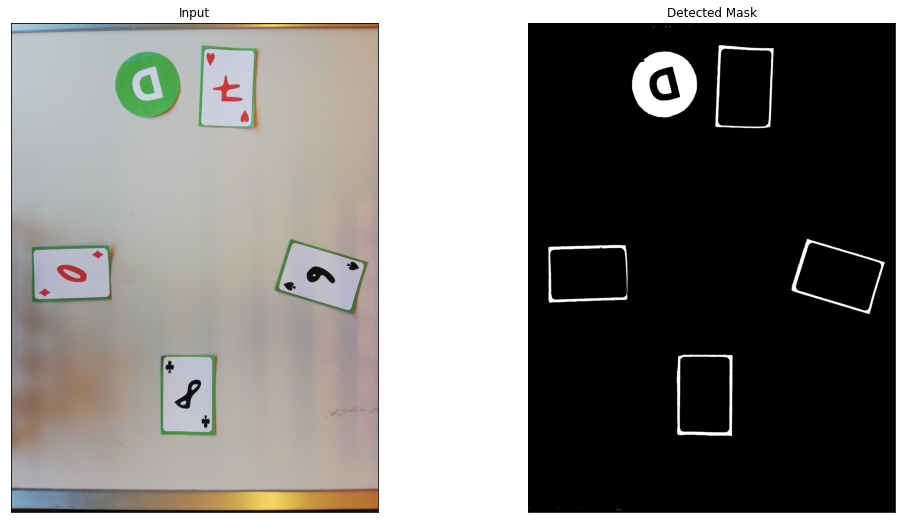

In [3]:
img = cv.imread('C:/Users/Neo/iapr/project/train_games/game4/7.jpg')
mask = preprocessing(img)

#  2. Display using subplots
fig, ax = plt.subplots(1, 2, figsize=(17, 9))
display_image(img, axes=ax[0])
ax[0].set_title('Input')
display_image(mask, axes=ax[1], cmap='gray')
ax[1].set_title('Detected Mask')
plt.show()

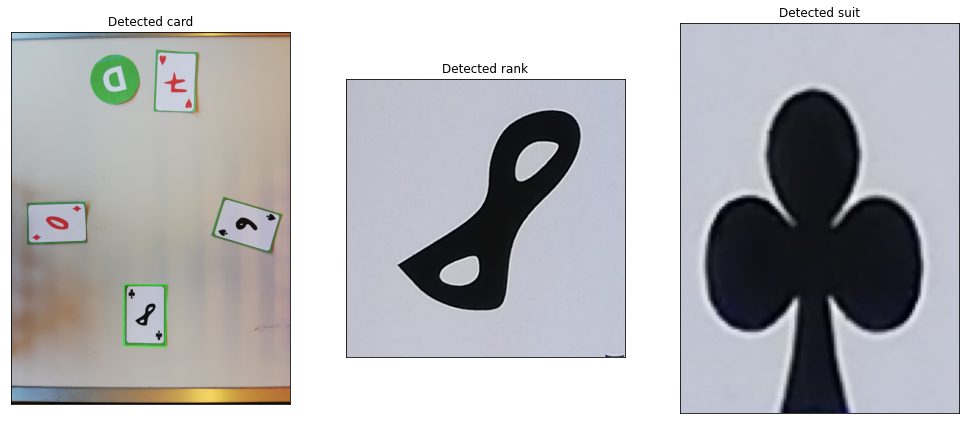

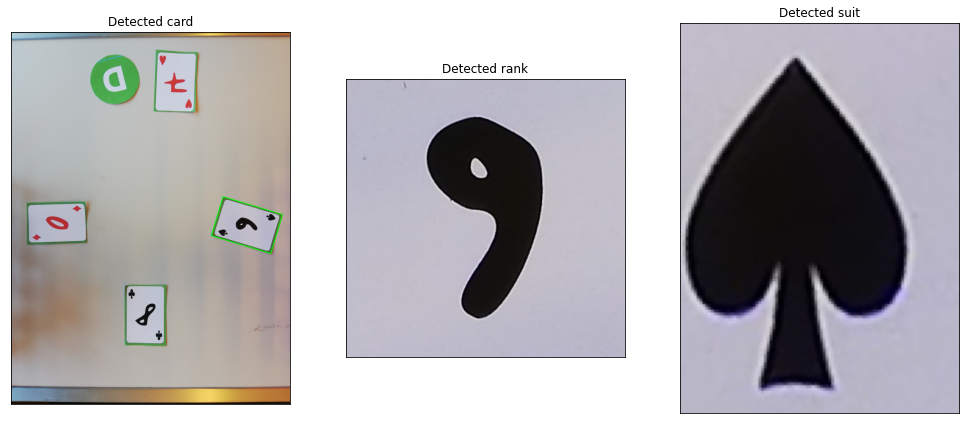

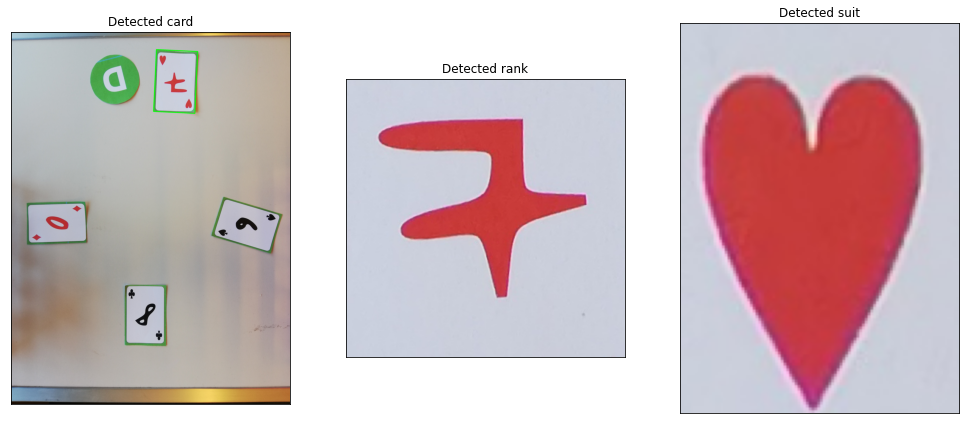

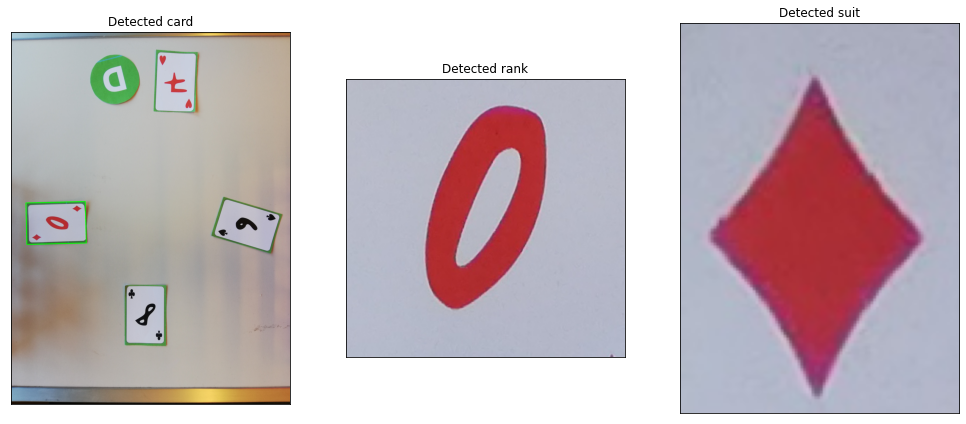

In [4]:
ranks, suits, dealer, centers, error = card_detection(img, mask)
if error:
    mask = preprocessing_new(img)
    ranks, suits, dealer, centers, error = card_detection(img, mask)

In [5]:
print('Dealer is player :{}'.format(find_dealer(centers, dealer) + 1))

Dealer is player :3
